## Task

Conduct EDA for TensorFlow transfer learning pipeline to forecast **weekly dengue cases** (`total_cases`) from 22 multivariate weather/environmental features.

### Dataset
Dengue ML datasets track environmental and temporal factors influencing Aedes mosquito breeding and virus transmission in tropical regions like San Juan and Iquitos.

- #### Temporal Features
    - **city**: Location identifier (e.g., 'sj' for San Juan, 'iq' for Iquitos)—captures city-specific mosquito/dengue patterns.
    - **year, weekofyear, week_start_date**: Time granularity for seasonality; dengue peaks during rainy seasons (weekofyear critical for lagged effects).

- #### Vegetation Indices (NDVI)
    - **ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw**: Normalized Difference Vegetation Index by city quadrant. Higher NDVI indicates lush vegetation providing mosquito shade/breeding sites; key for Aedes habitat detection via satellite.

- #### Precipitation \& Water
    - **precipitation_amt_mm**: Rainfall amount—creates standing water breeding sites.
    - **reanalysis_precip_amt_kg_per_m2, reanalysis_sat_precip_amt_mm**: Reanalysis (modeled) precipitation variants confirming observed rain.
    - **station_precip_mm**: Ground station measurements—most direct rain proxy.

- #### Temperature Metrics
    - **reanalysis_air_temp_k, reanalysis_avg_temp_k, reanalysis_max_air_temp_k, reanalysis_min_air_temp_k**: Reanalysis temps in Kelvin; optimal Aedes range 26-32°C accelerates larval development/virus replication.
    - **station_avg_temp_c, station_max_temp_c, station_min_temp_c**: Station temps in Celsius—ground truth validation.
    - **station_diur_temp_rng_c**: Diurnal range; wider swings stress mosquitoes.
    - **reanalysis_tdtr_k**: Temperature diurnal temperature range (reanalysis).

- #### Humidity \& Moisture
    - **reanalysis_dew_point_temp_k**: Dew point—direct humidity proxy; high values (>20°C) favor mosquito survival.
    - **reanalysis_relative_humidity_percent**: Relative humidity %—critical for egg/larval viability.
    - **reanalysis_specific_humidity_g_per_kg**: Absolute moisture content.


### Notebook sections
1. Get Data
2. Exploratory Data Analysis
3. Data Cleaning (TBC)
4. Feature Selection (TBC poss notebook 02)
5. Feature Engineering (TBC poss notebook 02)
6. Benchmark Model
7. Model Tuning  (TBC)
8. Model Evaluation  (TBC, poss notebook 03)

In [1]:
import sys
import os
from pathlib import Path
from typing import List, Tuple, Any
import gc

# Set one level up as project root|
if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
    
from src.config import ProjectConfig  # project config file parser
from src.utils.eda import value_streaks, top_correlations
from src.utils.visualizations import compute_correlations_matrix, \
                display_distributions, random_color, random_colormap, \
                display_timeseries

import pandas as pd
import numpy as np
import random
import time
from datetime import timedelta

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# from matplotlib.axis import Axis
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
import seaborn as sns

In [2]:
cnfg = ProjectConfig.load_configuration()
PATH_TO_RAW_DATA = cnfg.data.dirs["raw"]
FILE_TRAIN_RAW= cnfg.data.files["features_train"]
FILE_TEST_RAW = cnfg.data.files["features_test"]
FILE_LABELS_RAW = cnfg.data.files["labels_train"]
TARGET = "total_cases"

### Get Data

In [3]:
df_train_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TRAIN_RAW, parse_dates=["week_start_date"])
df_test_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_TEST_RAW, parse_dates=["week_start_date"])
df_labels_raw = pd.read_csv(PATH_TO_RAW_DATA / FILE_LABELS_RAW)
list_raw_df = [df_train_raw, df_test_raw, df_labels_raw]

In [4]:
for df in list_raw_df:
    display(df.sample(1))   

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1166,iq,2004,49,2004-12-02,0.201943,0.159367,0.159043,0.241086,53.01,299.177143,...,36.83,87.13,53.01,18.11,10.957143,27.9,11.0,34.1,22.4,64.0


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
257,sj,2013,15,2013-04-09,-0.1176,-0.0082,0.1927,0.170429,0.0,299.057143,...,0.7,78.285714,0.0,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


,city,year,weekofyear,total_cases
1001,iq,2001,40,0


### Exploratory Data Analysis

- #### Dataframe level EDA

In [5]:
for df in list_raw_df:
    print(df.dtypes, '\n' , '+' * 120)

city                                             object
year                                              int64
weekofyear                                        int64
week_start_date                          datetime64[ns]
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

**Conclusion**: Datatypes look clean

In [6]:
df_labels_raw.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
year,1456.000000,2001.031593,5.408314,1990.000000,1997.000000,2002.000000,2005.000000,2010.000000
weekofyear,1456.000000,26.503434,15.019437,1.000000,13.750000,26.500000,39.250000,53.000000
total_cases,1456.000000,24.675137,43.596000,0.000000,5.000000,12.000000,28.000000,461.000000


**Conclusion**: Skewed target, outliers

In [7]:
#df_train_raw.describe().T

In [8]:
df_labels_raw[["year", "weekofyear"]].equals(df_train_raw[["year", "weekofyear"]])

True

**Conclusion**: Non-target columns in target file and corresponding columns in training file appear to be matching. No issue here.

In [9]:
for df in list_raw_df:
    shp = df.shape
    print(f"Dataframe shape: {shp}")
    print("\n\tNaN percentages in Dataframe:")
    print(round(((df.isnull().sum() / shp[0]).sort_values(ascending=False) * 100), 2))
    print('=' * 120)

Dataframe shape: (1456, 24)

	NaN percentages in Dataframe:
ndvi_ne                                  13.32
ndvi_nw                                   3.57
station_diur_temp_rng_c                   2.95
station_avg_temp_c                        2.95
station_precip_mm                         1.51
ndvi_se                                   1.51
ndvi_sw                                   1.51
station_max_temp_c                        1.37
station_min_temp_c                        0.96
precipitation_amt_mm                      0.89
reanalysis_sat_precip_amt_mm              0.89
reanalysis_relative_humidity_percent      0.69
reanalysis_tdtr_k                         0.69
reanalysis_specific_humidity_g_per_kg     0.69
reanalysis_max_air_temp_k                 0.69
reanalysis_precip_amt_kg_per_m2           0.69
reanalysis_min_air_temp_k                 0.69
reanalysis_dew_point_temp_k               0.69
reanalysis_avg_temp_k                     0.69
reanalysis_air_temp_k                     0.69


**Conclusion**: NaN issue

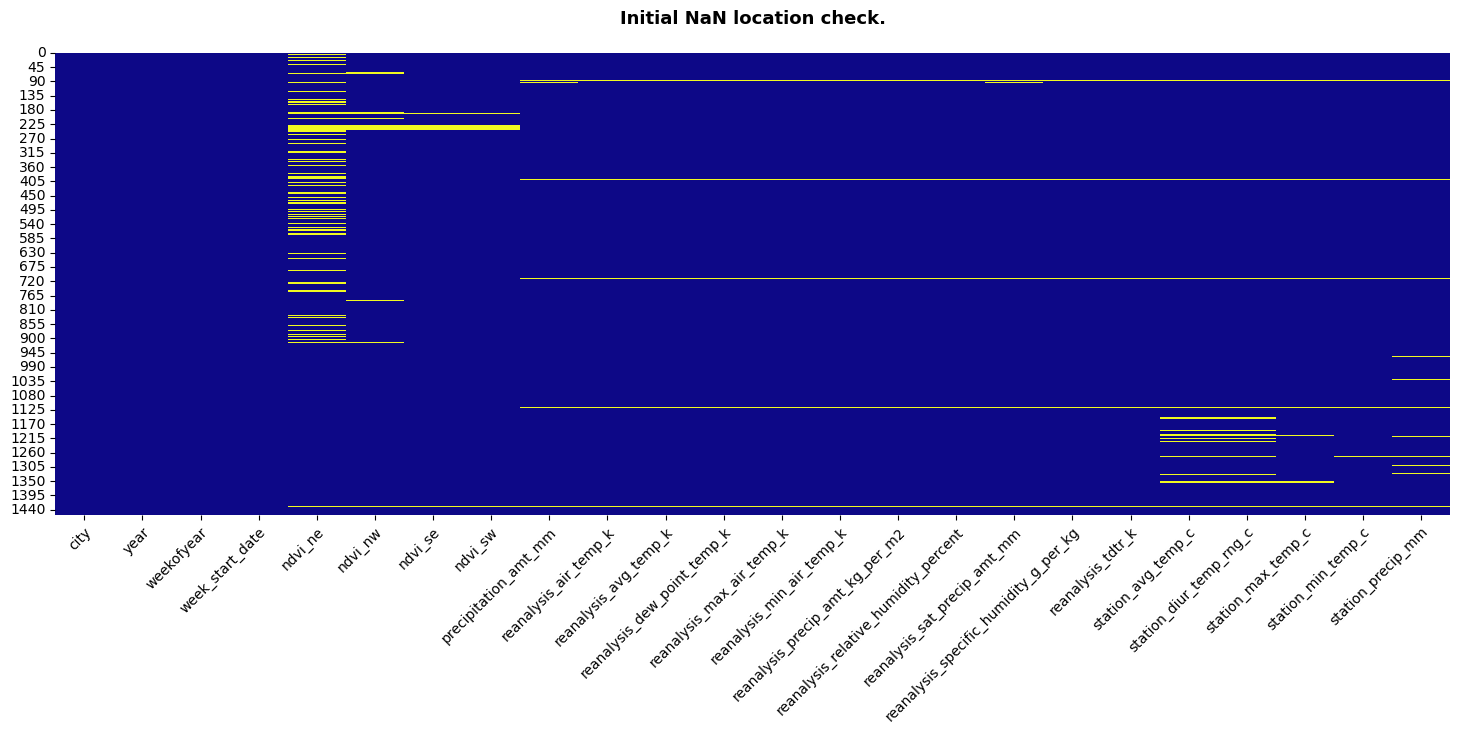

In [10]:
plt.figure(figsize=(18, 6))  # df_train_raw.shape[1]
sns.heatmap(df_train_raw.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN location check.\n", 
          fontsize=13, fontweight="bold")
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [11]:
# for city, group in df_train_raw.groupby(by="city"):
#     shp = group.shape
#     print(f"Dataframe shape for {city}: {shp}")
#     print("\n\tNaN percentages in Dataframe:")
#     print(round(((group.isnull().sum() / shp[0]).sort_values(ascending=False) * 100), 2))
#     print('=' * 120)

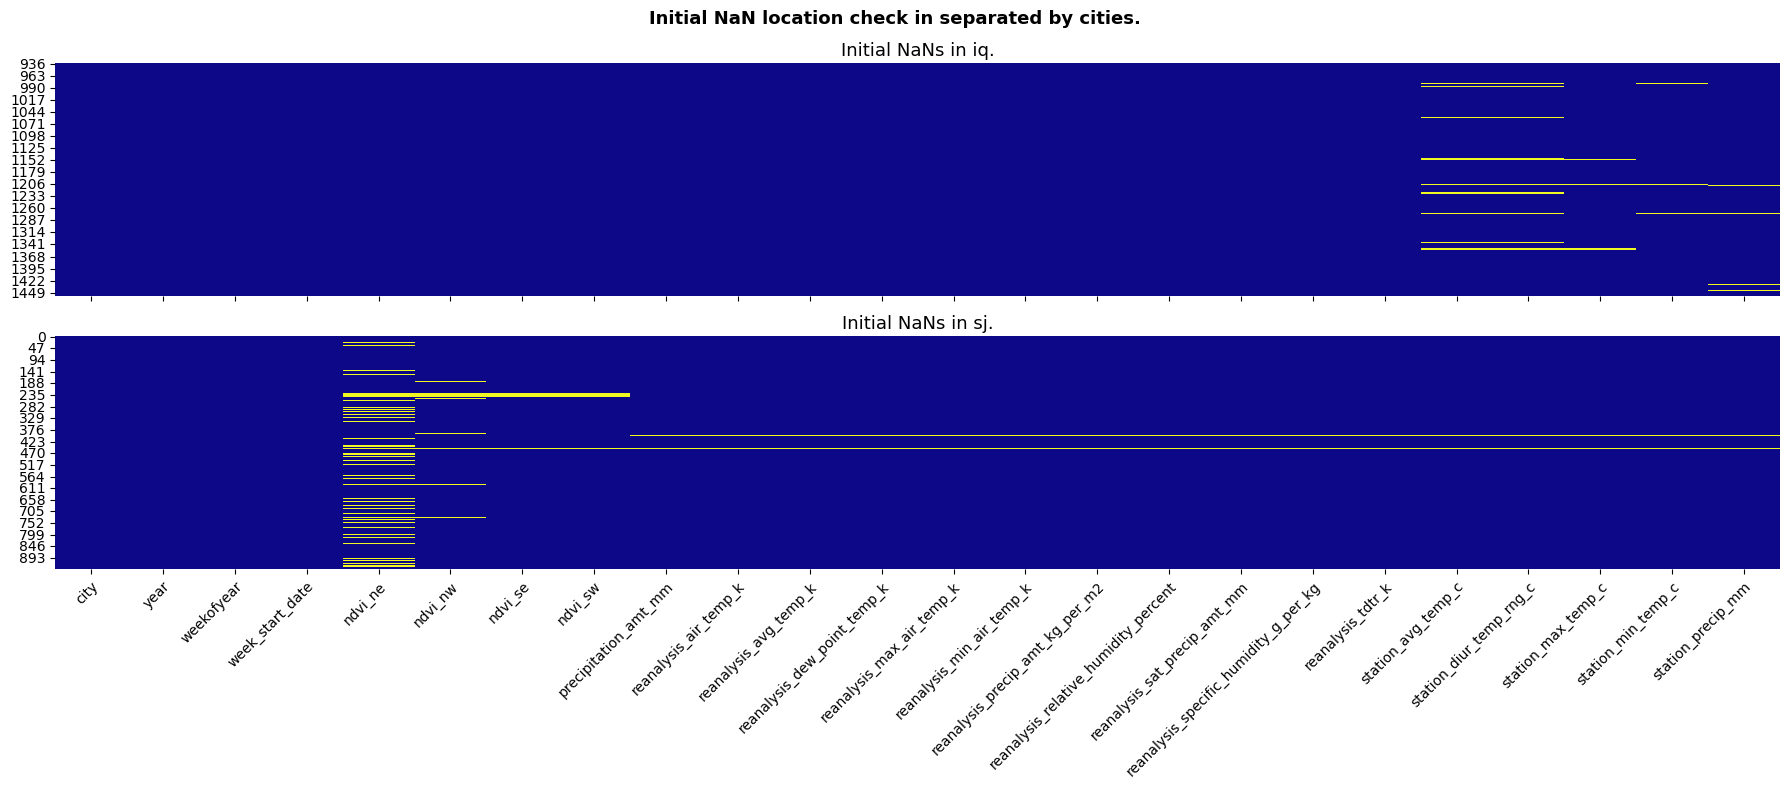

In [12]:
n_subplots = df_train_raw["city"].nunique()
fig, axs = plt.subplots(nrows=n_subplots, figsize = (18, n_subplots * 4), 
                            sharex=True)
index = 0
for city, group in df_train_raw.groupby(by="city"):
    sns.heatmap(group.isnull(), cmap='plasma', cbar=False, ax=axs[index])
    axs[index].set_title(f"Initial NaNs in {city}.", 
              fontsize=13)
    index += 1
    
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.suptitle(f"Initial NaN location check in separated by cities.", 
          fontsize=13, fontweight="bold")
fig.tight_layout()
plt.show()

**Conclusion**:
- potential for row-wise remowal where most of datapoint features lack values
- columnwise *"ndvi_ne"* feature:
    - sparse, but importand (vegetation data crucial for mosquitoes) - attempt to interpolate from other rows of the same feature
- possible imputation for temperatures where reanalysis data available
- Missing value patterns between San Juan and Iquitos do differ

In [13]:
nan_threshold = 2
ndvi_colnames = [column for column in df_train_raw.columns if column.startswith("ndvi")]

for col in ndvi_colnames:
    print(f"NaN streaks longer {nan_threshold} than weeks for {col} feature:")
    display(value_streaks(data=df_train_raw, column=col, value=np.nan,
                                 run_threshold=nan_threshold))

NaN streaks longer 2 than weeks for ndvi_ne feature:


,first_pos,last_pos,streak_len
0,228,242,15
1,13,15,3
2,355,357,3
3,470,472,3
4,475,477,3
5,630,632,3
6,727,729,3


NaN streaks longer 2 than weeks for ndvi_nw feature:


,first_pos,last_pos,streak_len
0,228,242,15


NaN streaks longer 2 than weeks for ndvi_se feature:


,first_pos,last_pos,streak_len
0,229,242,14


NaN streaks longer 2 than weeks for ndvi_sw feature:


,first_pos,last_pos,streak_len
0,229,242,14


**Conclusion:** Entire season missing for all vegetation data quadrants.:
- Regardles will keep rows and interpolate data from other years data
- There are different missing data patterns between two datset cities:
    - For imputing use only relevant city data as both climate and vegetation differ San Juan and Iquitos 

**Preprocessing tactics for NaNs**:
1) remove obvious rows (eg sparsity > 50%)
2) Figure out trattegy for San Juan that is missing ~20% data for 'ndvi_ne' (most likely keep, if can build other quadrants)
3) check target distribution and if some outlier rows have to be removed
4) reevaluet what is left for imputation:
    - imputation options for weather and short term ndvi_ breaks data (time sensitive):
        1) Use only relevant city data/group for imputation
        2) Impute accordibng to feature importance vs importance for target (mosqiotoe breeding):
            1. station_precip_mm (CRITICAL) - Creates breeding sites
            2. station_avg_temp_c (CRITICAL) - Optimal 26-32°C for development  
            3. station_max_temp_c (HIGH) - Heat stress threshold (>32°C kills)
            4. ndvi_ features: Shade/habitat (MEDIUM):
                1) if long missing streeks missing (etire season):
                    - 5-12 weeks missing Seasonal mean from same quadrant in all other years for same week
                    - 15-18+ weeks	DROP COLUMN or flag as unreliable - Entire growing season lost 
                2) For shorter periods (1-4 weeks) NaNs Use interpolate(method='time') -> lienar between existing time points???)
            6. station_min_temp_c (MEDIUM) - Night survival threshold
            7. station_diur_temp_rng_c (LOW) - Secondary stress indicator
        3) Impute if reanalysis columns available
        4) check time sensitive imputation methods (simpler - forward fill last valid value forward with ffill())

In [14]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def compute_correlations_matrix(data: pd.DataFrame,
#                                annot: bool = False,
#                                figsize: tuple = (17, 5),
#                                 cmap:str = "PuBuGn"):
#     """
#     Compute and display a heatmap of the correlation matrix for numerical features.    
#     :param data: pandas DataFrame containing the input data.
#     :return: pandas DataFrame of the correlation matrix.
#     """
#     plt.figure(figsize=figsize)
#     correlation_matrix = data.select_dtypes(include="number").corr()
#     triangular_matrix = np.triu(correlation_matrix, k=1)

#     sns.heatmap(data=correlation_matrix,
#                 center=0,
#                 cmap=cmap,
#                 cbar=False,
#                 # cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
#                 annot=annot,
#                 linewidths=0.5,
#                 mask=triangular_matrix,
#                )
#     plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
#     plt.title("Correlation matrix for feature and target columns.",
#                 fontsize=18, fontweight='bold', y=0.95)
#     plt.tight_layout();

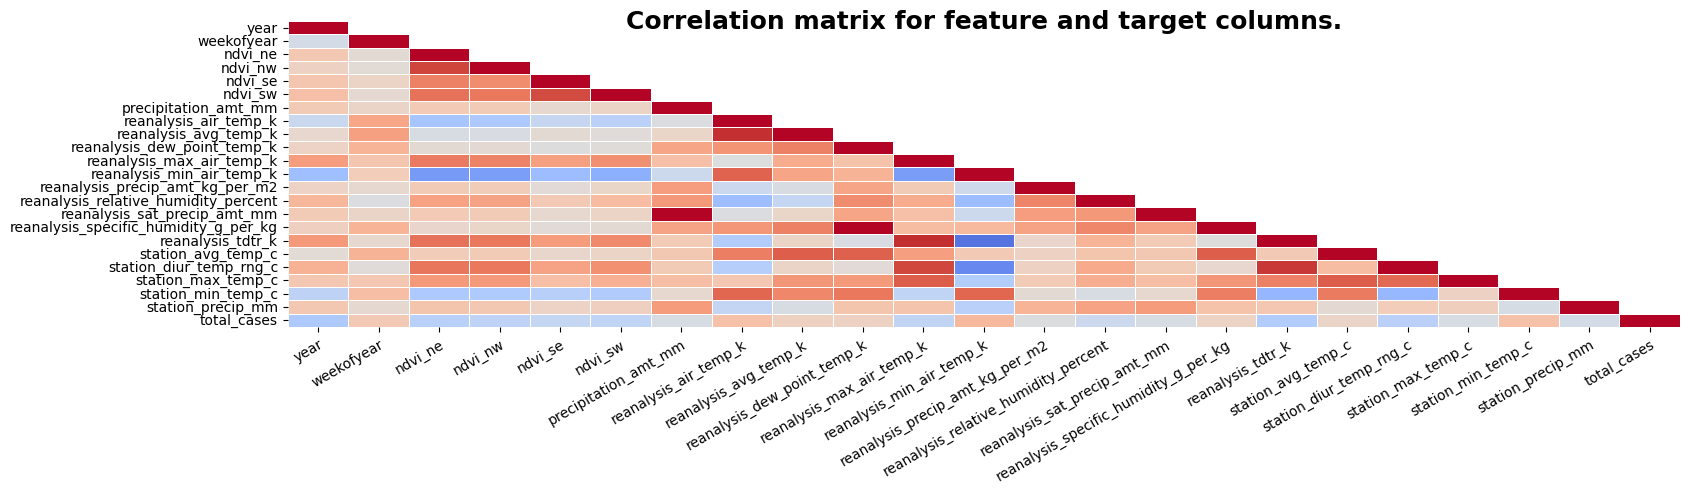

In [15]:
compute_correlations_matrix(
    data=pd.concat([df_train_raw, df_labels_raw[TARGET]], axis=1),
    cmap="coolwarm",
    # annot=True
)

In [16]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def top_correlations(data: pd.DataFrame, corr_threshold:float=0.95) -> pd.Series:
#     """
#     Identify and return highly correlated feature pairs above a specified threshold.
#     :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
#     :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
#     :return: A pandas Series with multi-index (feature pairs) and correlation values.
#     """
#     correlations = data.select_dtypes(include="number").corr()
#     correlations = correlations.unstack().sort_values(ascending=False)
#     correlations = correlations[(correlations.abs() > corr_threshold) &
#         (correlations.index.get_level_values(0) != correlations.index.get_level_values(1))]
#     correlations = correlations.drop_duplicates()
#     return correlations

In [17]:
corr_threshold = 0.8
print(f"Features with correlation exceeding {corr_threshold}:")
top_correlations(
    data=df_train_raw,
    corr_threshold=corr_threshold
)

Features with correlation exceeding 0.8:


precipitation_amt_mm                   reanalysis_sat_precip_amt_mm    1.000000
reanalysis_specific_humidity_g_per_kg  reanalysis_dew_point_temp_k     0.997051
reanalysis_max_air_temp_k              reanalysis_tdtr_k               0.918578
reanalysis_air_temp_k                  reanalysis_avg_temp_k           0.901777
reanalysis_tdtr_k                      station_diur_temp_rng_c         0.881176
ndvi_nw                                ndvi_ne                         0.850902
reanalysis_max_air_temp_k              station_diur_temp_rng_c         0.834263
ndvi_se                                ndvi_sw                         0.820924
reanalysis_min_air_temp_k              reanalysis_tdtr_k              -0.815511
dtype: float64

 **Conclusions** a lot of multicolinearity:
- Not an issue per se for LSTM, but introduces redundancy. Therefore:
    - Remove identical:
        -  "reanalysis_sat_precip_amt_mm" and near identical "reanalysis_dew_point_temp_k"
    - remove highly correlated infered feature:
        - "reanalysis_avg_temp_k"
    - keep potential cross domain feature despite high correlations:
        - "reanalysis_tdtr_k"
    - keep direct sation measurement data despite correlations with reanalysis data:
        - "station_diur_temp_rng_c"
    -  cluster vegetation in North and South features:
        - 'ndvi_ne' with 'ndvi_nw' and 'ndvi_se' with 'ndvi_sw (AFTER NaN interpolation)

In [18]:
# sns.pairplot(df_train_raw, diag_kind="kde")  # resource demanding and creates notebook clutter

- #### Feature level EDA

In [19]:
# Moved to/Imported from src.utils.eda
# DELETE  for cleanup

# def display_distributions(data: pd.DataFrame, features: List[str],
#                           fig_width: int = 17,
#                           hue_palette: Tuple[str | None, Any | None] = (None, None),
#                           x_range: Tuple[int,int] | None = None,
#                           title_prefix: str=None) -> None:
#     """Display distribution graphs for specified numerical features.
#     All subplots share the same x-axis scale.
#     :param data: DataFrames with numerical categories for visualization.
#     :param features: list of column names/features  from 'data' Dataframe.
#     :param hue_palette: Coloring by category. Use (None, None) for no hue 
#                 coloring (default).
#     :param x_range: Optional tuple (min, max) to set uniform x-axis limits 
#                 across all subplots (default: None, auto-scaled).
#     :param title_prefix: Optional, prefix for visualization title.
#     """
#     n_subplots = len(features) * 2
#     fig, axs = plt.subplots(nrows=n_subplots, figsize = (fig_width, n_subplots * 2), 
#                             sharex=True
#                            )                   
#     index = 0
#     for feature in features:
#         sns.boxenplot(data=data, x=data[feature],
#                       hue=hue_palette[0],
#                       palette=hue_palette[1],
#                       color=random_color(), 
#                       ax=axs[index])
#         sns.kdeplot(data=data, x=data[feature], fill=True,
#                       hue=hue_palette[0],
#                       palette=hue_palette[1],
#                     color=random_color(), 
#                     ax=axs[index + 1])
#         index += 2
        
#     if title_prefix is not None:
#         fig.suptitle(f"{title_prefix} feature distribution analysis.", fontsize=18,
#                     fontweight='bold', y=0.98)
#     else:
#         fig.suptitle("Feature distribution analysis.", fontsize=18,
#                     fontweight='bold', y=0.98)

#     if x_range is not None:
#         axs[0].set_xlim(x_range)
        
#     fig.tight_layout();

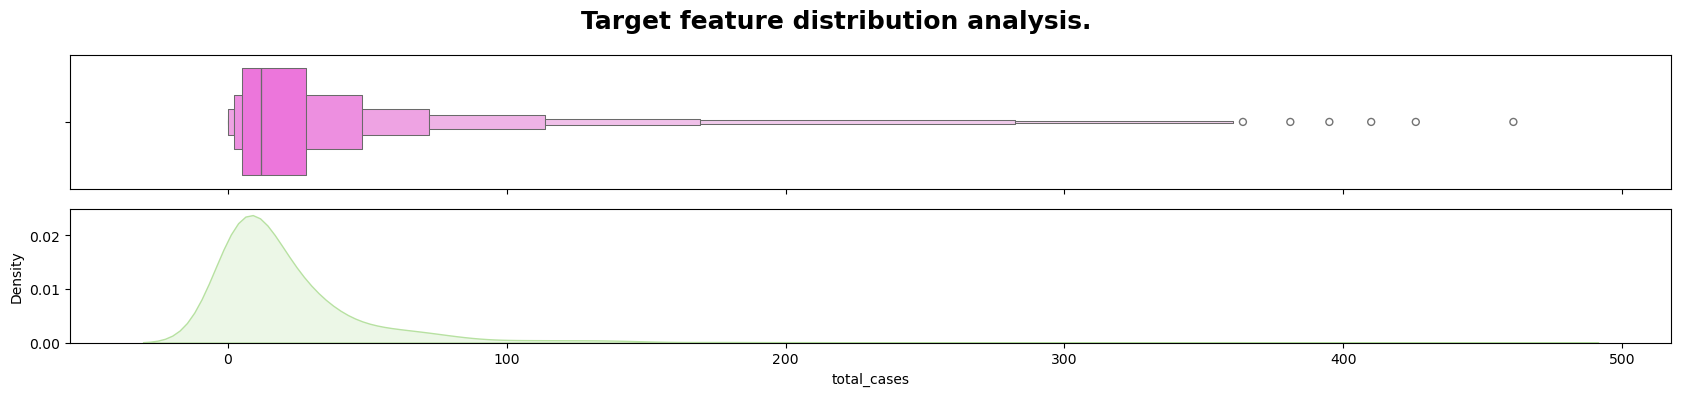

In [20]:
display_distributions(df_labels_raw, features=[TARGET], title_prefix="Target")

**Conclusion** Skew + outliers:

**Preprocessing tactics for outliers:**
- Target ("total_cases")
    - If tree models used (eg LightGBM) - no issue, trees are not sensitive to outliers:
        - use huber loss for extra safety when handling tails
        - clip extreme values for dengue context realistic predictions
        - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
    - RNNs (eg LSTM) are outlier sensitive (gradient instability, hidden state patterns loose importance at peaks, scaling):
        - Log transform
        - Scale (RobustScaler  with IQR is more outlier resistant)
        - apply huber loss
    - clip (!= remove) extreme values for target for both models, separate clipping by city (outlier in Iquitos may not be an outlier in much larger San Juan)
- Features:
    - clip globally (less complex, city specific can mess up transfer learning
    - clip for both tree and RNN
    - RobustScaler for RNN
    - RobustScaler may be redunndant for tree models, but if it simplifies pipeline - no harm.
        - rainfall:
            - clip to ~ 300 mm (test 99.5 percentile)
        - temperature:
           - are specific extremes are from 20 - 40 C (test 99.5 percentile)
           - clip min to ~ 20
           - clip max to ~ 40
        - vegetation (ndvi features)
            - dataset ranges from -0.456100 (water bodies) to 0.546017 (rainforest) are possible
            - no need for clipping, but can apply IQR clip as preventive measure for future data/prediction inputs

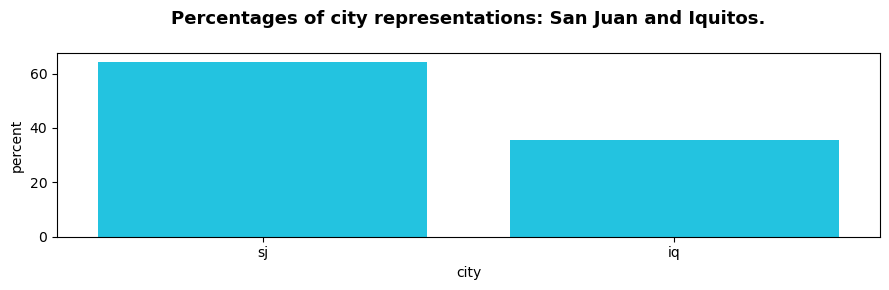

In [21]:
plt.figure(figsize=(9, 3))  # df_train_raw.shape[1]
sns.countplot(data=df_train_raw, x="city", color=random_color(),
             stat="percent"
             )
plt.title("Percentages of city representations: San Juan and Iquitos.\n", 
          fontsize=13, fontweight='bold')
plt.tight_layout();

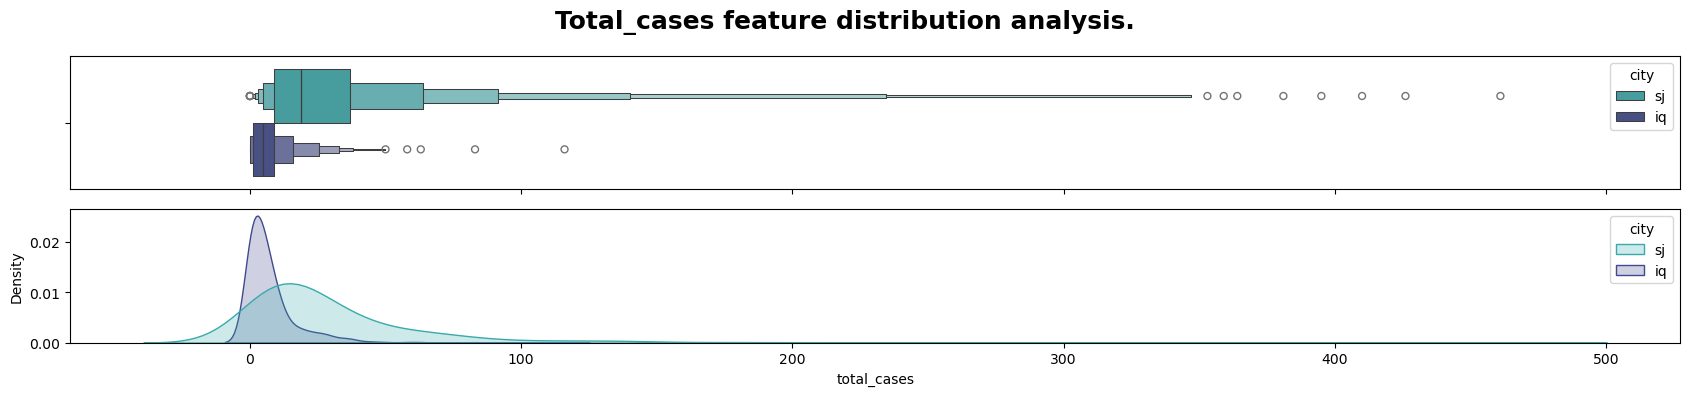

In [22]:
display_distributions(data = df_labels_raw.assign(city=df_train_raw["city"]),
                      hue_palette=("city", random_colormap()),
                     features=[TARGET], title_prefix=TARGET.capitalize(),
                     )

**Conclusions**: Dengue case distribution patterns in both cities are similar, however:
- San Juan has wider Dengue case range
- San Juan has higher Dengue case counts
- San Juan has more data
- As San Juan has both - more data and wider range, use San Juan dataset for pretraining.

***Distributions of selected numerical fatures***:
- except inferred reanalysis features
- except vegetation features
- features with least normal distributions selected for this visualization and analisys
- outliers in every feature

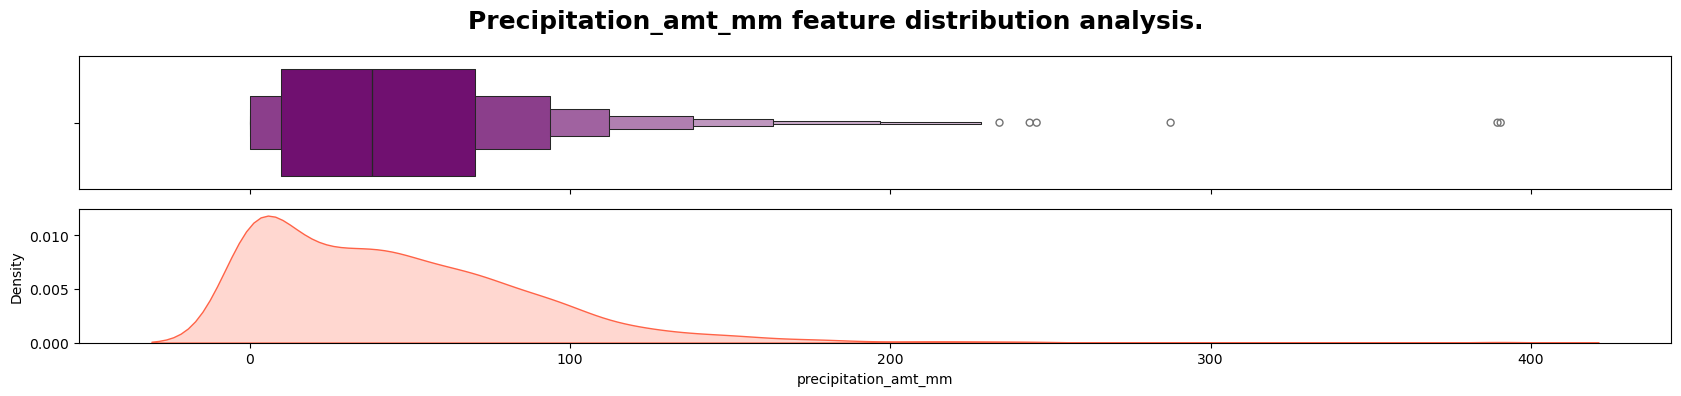

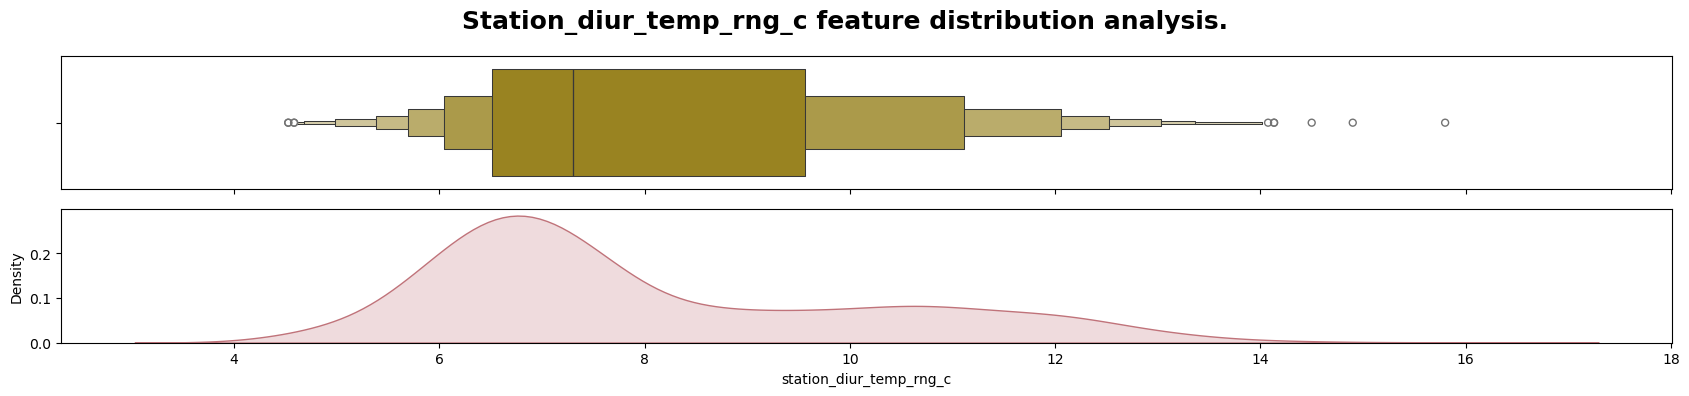

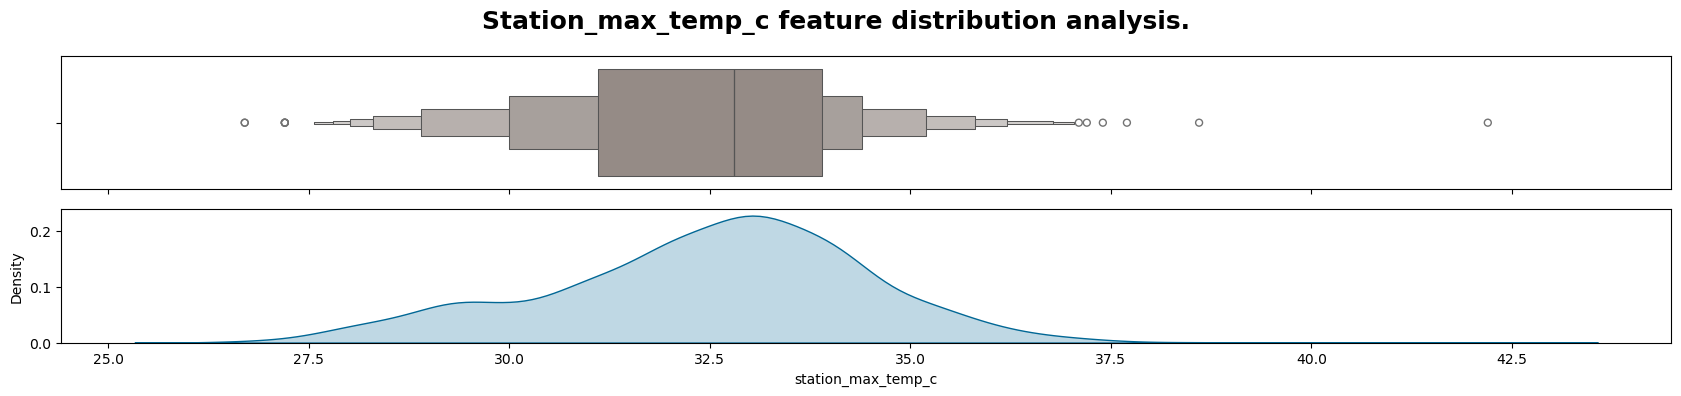

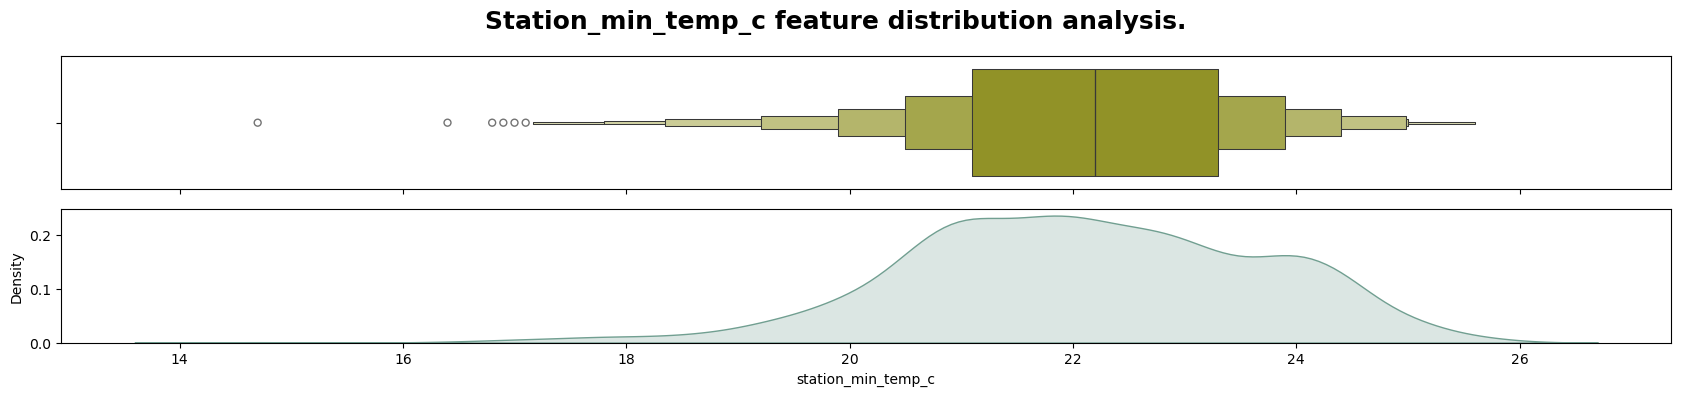

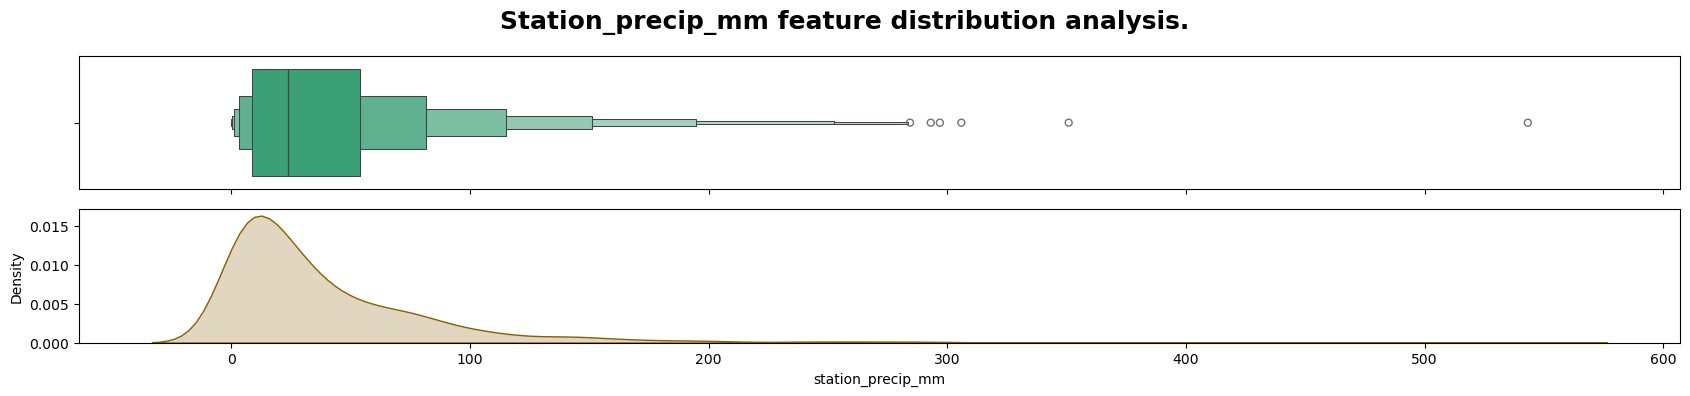

In [23]:
selected_distro_EDA_features = ["precipitation_amt_mm", "station_diur_temp_rng_c", "station_max_temp_c",
       "station_min_temp_c", "station_precip_mm"]
# selected_distro_EDA_features = [feature for feature in df_train_raw.select_dtypes("float") if not feature.startswith("reanalysis")]  # used for outlier check

for numeric_feature in selected_distro_EDA_features:
    display_distributions(data=df_train_raw[selected_distro_EDA_features],
                          features=[numeric_feature],
                          title_prefix=numeric_feature.capitalize())

**Conclusion**:
- Distributions are fairly Normal even for the most bimodal features
- Some of this multi-modality can be explained by different modes between San Juan and Iquitos data:
    - Even more reason to experiment with training datasets separately
-   station_precip_mm distribution look very similar to target distribution - both in shape and in values

***Comparative distributions for city level numerical fatures, except inferred reanalysis features***
- station_avg_temp_c (ilustrates if the city is within dengue friendly 27-31C range)
- station_precip_mm - local sation level rainfall data
- ndvi_avg - average of vegetation quadrant data to ilustrate cities

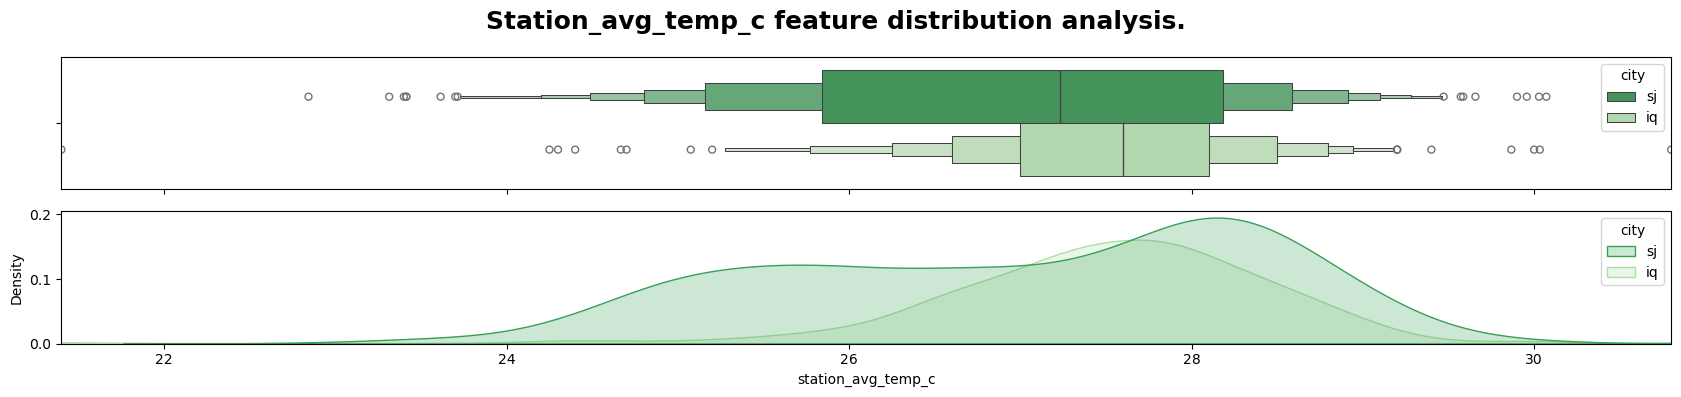

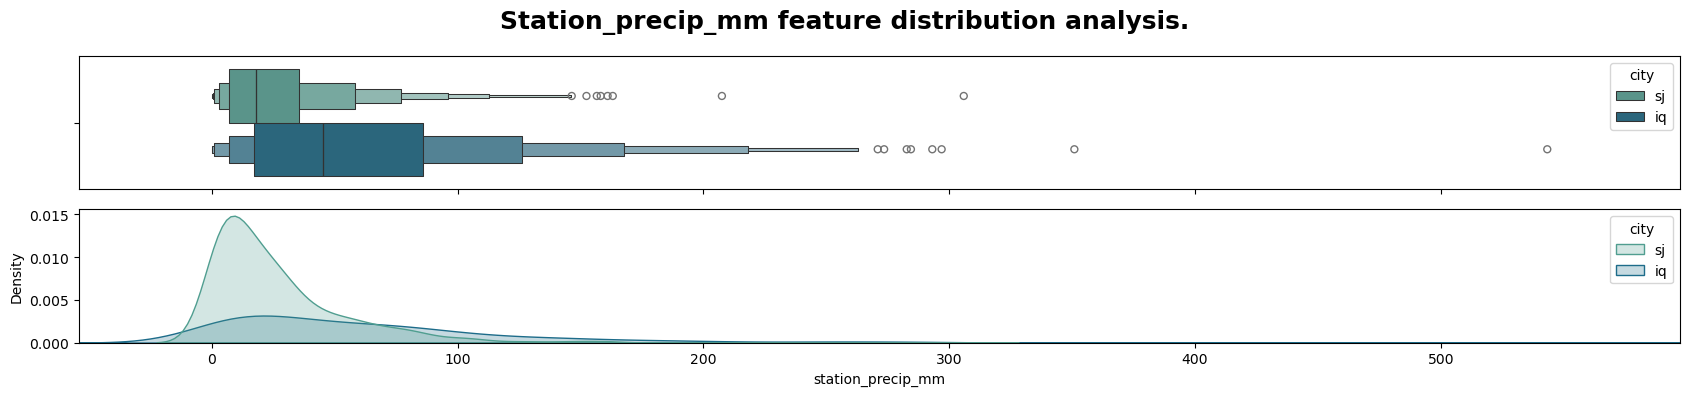

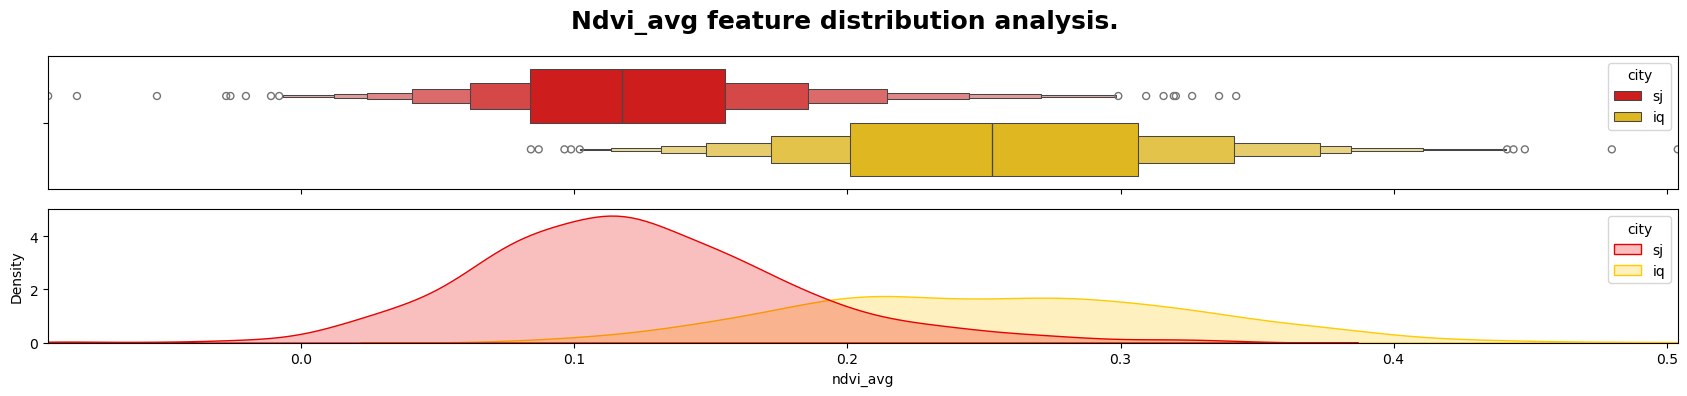

In [24]:
# df_numerical_raw = df_train_raw.select_dtypes("float")
selected_city_features = ["station_avg_temp_c", "station_precip_mm", "ndvi_avg",
                          # "station_diur_temp_rng_c"  # to test if seperating city data explains multi-modality for combined data.  It does in this case.
                         ]
veg_features = [feature for feature in df_train_raw.columns if feature.startswith("ndvi")]

df_temp_viz = df_train_raw.assign(ndvi_avg=lambda x: x[veg_features].mean(axis=1))[selected_city_features]
df_temp_viz["city"] = df_train_raw["city"]
for numerical_feature in selected_city_features:
    start, end = df_temp_viz[numerical_feature].min(), df_temp_viz[numerical_feature].max()
    x_padding = (end - start) // 10
    start, end = start - x_padding, end + x_padding
    display_distributions(data=df_temp_viz, features=[numerical_feature],
                          hue_palette=("city", random_colormap(seaborn=True, n_colors=2)),
                          x_range=(start, end), 
                          title_prefix=f"{numerical_feature.capitalize()}")

del df_temp_viz  # clean up temporary dataframe

**Conclusion** San Juan and Iquitos cities have distinct data distributions in all selected features, indicating more rain, more vegetation and slightly higher temperatures in Iquitos.

In [25]:
df_labels_raw.columns

Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')

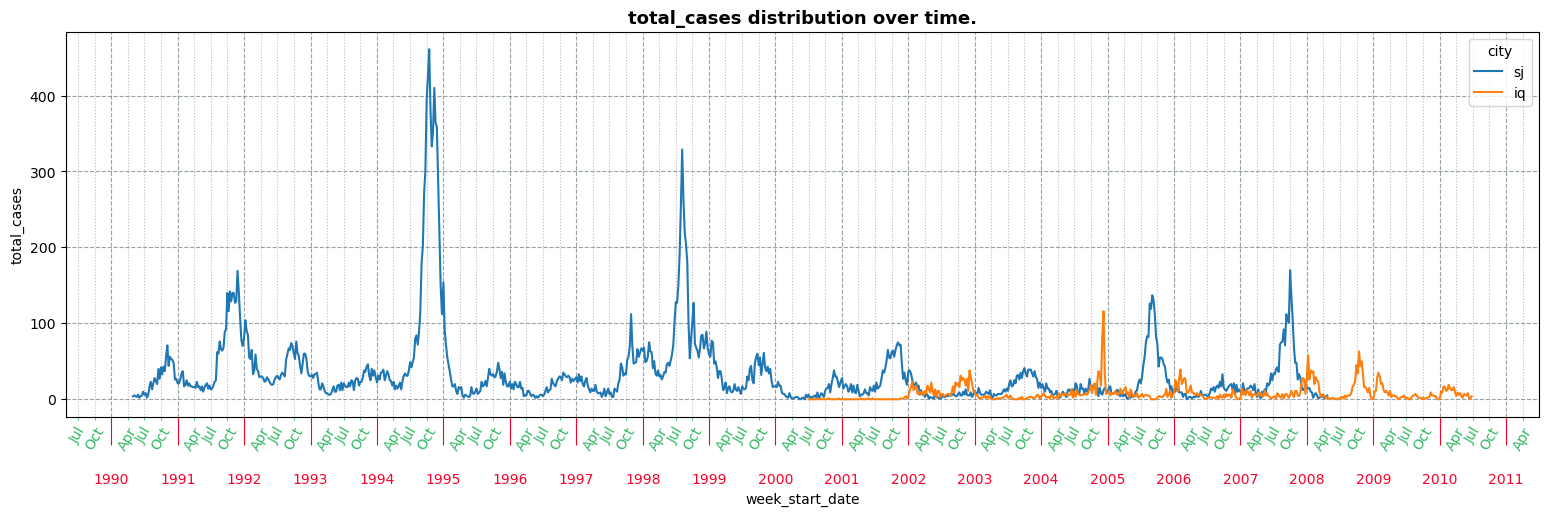

In [26]:
# Moved to/Imported from src/utils/visualizations.py
# DELETE  for cleanup

# def display_timeseries(data: pd.DataFrame, x: str, y: str,
#                         hue: str | None = None, grid: bool = True,
#                         shift: int | None = None,
#                         month_ticks: Tuple[int, ...] = (1,4,7,10),
#                         title_prefix: str | None = None) -> None:
    
#     """
#     Display timeseries line plots for specified features.
#     All subplots share the same x-axis scale.
    
#     :param data: DataFrame with numerical categories for visualization.
#     :param x: Column name for x-axis (datetime).
#     :param y: Column name for y-axis.
#     :param hue: Optional column name for hue coloring (default: None).
#     :param shift: Optional number of weekly periods to shift the time axis 
#             for an overlaid comparison line.
#     :param grid: Whether to show grid lines (default: True).
#     :param month_ticks: Tuple of month numbers for minor x-axis ticks (default: (1,4,7,10) quarterly).
#     :param title_prefix: Optional, prefix for visualization title.
#     """
    
#     fig, ax = plt.subplots(figsize=(19, 5))
#     sns.lineplot(data=data, x=x, y=y, hue=hue)
    # if shift is not None:
    #     shifted_data = data[[x, y, hue]]
    #     shifted_data[x] = shifted_data[x] + pd.Timedelta(52, "W")
    #     sns.lineplot(data=shifted_data, x=x, y=y, hue=hue, linestyle=":")
        
#     # # Configure x-axis ticks (quarterly minors, yearly majors)
#     ax.xaxis.set_minor_locator(MonthLocator(bymonth=month_ticks))  
#     ax.xaxis.set_minor_formatter(DateFormatter(fmt="%b"))
#     ax.xaxis.set_major_locator(YearLocator())
    
#     # Prettu Alternative:
#     # ax.xaxis.set(major_locator=YearLocator(),
#     #              minor_locator=MonthLocator(bymonth=month_ticks),  # qarterly ticks
#     #              minor_formatter=(DateFormatter(fmt="%b")))
        
    
#     # Style ticks
#     ax.tick_params(axis='x', which="major", pad=20, length=20,
#                    colors=random_color()  # remove for cleanup
#                   )
#     ax.tick_params(axis='x', which="minor", labelrotation=60,
#                   colors=random_color()  # remove for cleanup
#                   )
    
#     # Grid styling
#     if grid:
#         plt.grid(alpha=0.7,
#             linestyle="dashed",
#             color=random_color()  # remove for cleanup
#         )
#         plt.grid(alpha=0.5, axis='x', which="minor", linestyle="dotted",
#                 color=random_color()  # remove for cleanup
#                 )

#     if title_prefix is not None:
#         plt.title(f"{title_prefix} distribution over time.",
#                     fontsize=13, fontweight="bold");
#     else:
#         plt.title("Target distribution over time.",
#                  fontsize=13, fontweight="bold");


display_timeseries(data=df_train_raw[["city", "week_start_date"]].assign(total_cases=df_labels_raw[TARGET]),
                   x="week_start_date",
                   y=TARGET,
                   hue="city",
                   title_prefix=TARGET)

In [28]:
df_train_raw["week_start_date"].duplicated().sum()

407

In [29]:
for _, df in df_train_raw.groupby(by="city"):
    print(df["week_start_date"].duplicated().sum())

0
0


**Conclusions**:
- time data do not overlap for 407 rows - when separated by cities, no duplications:
    - not an issue for tree based models
    - for RNN need to encode numerical city feature
    - for city-wise transfer learning - overlaping dates is an asset
- zero values for almost 1.5 years in Iquitos
- Some annual patterns in San Juan,

In [30]:
for city, df in df_labels_raw.groupby(by="city"):
    print(f"Zero target values in {city}: {len(df[df[TARGET] == 0])}")

Zero target values in iq: 96
Zero target values in sj: 4


**Conclusion**: Insignificant zero 'total_case' values in San Juan

In [31]:
zero_one_targets = value_streaks(data=df_labels_raw, column=TARGET, value=range(2),
                             run_threshold=5)
print("Zero and one consecutive value streaks for target data ('total dengue cases).")
zero_one_targets

Zero and one consecutive value streaks for target data ('total dengue cases).


,first_pos,last_pos,streak_len
0,936,1010,75
1,1079,1087,9
2,1095,1100,6
3,1347,1352,6


In [32]:
print("Target data for second longest low value streak.")
df_labels_raw.iloc[zero_one_targets["first_pos"][1]:zero_one_targets["last_pos"][1] + 1]

Target data for second longest low value streak.


,city,year,weekofyear,total_cases
1079,iq,2003,14,0
1080,iq,2003,15,0
1081,iq,2003,16,0
1082,iq,2003,17,0
1083,iq,2003,18,1
1084,iq,2003,19,1
1085,iq,2003,20,1
1086,iq,2003,21,1
1087,iq,2003,22,1


**Conclusion** There is a single 75 week long low value (0 and 1, mostly 0) for target 'total_case' data in  Iquitos. Next longest streak of 9 weeks already appears credible low-infection period for sparsely populated place with mostly single infection data:
   - such imbalance over long time period, especially at the beginning of dataset, can degrade feedforward ML model performance

**Preprocessing tactics for low value target streaks**:
- Drop 75 rows of initial zero/low value streaks for feedforward ML models (LightGBM, MLPRegressor, SFNN)
- keep as is for RNNs (LSTM) and transfer learning - can handle long zero sequences ('forgets' initial streak)

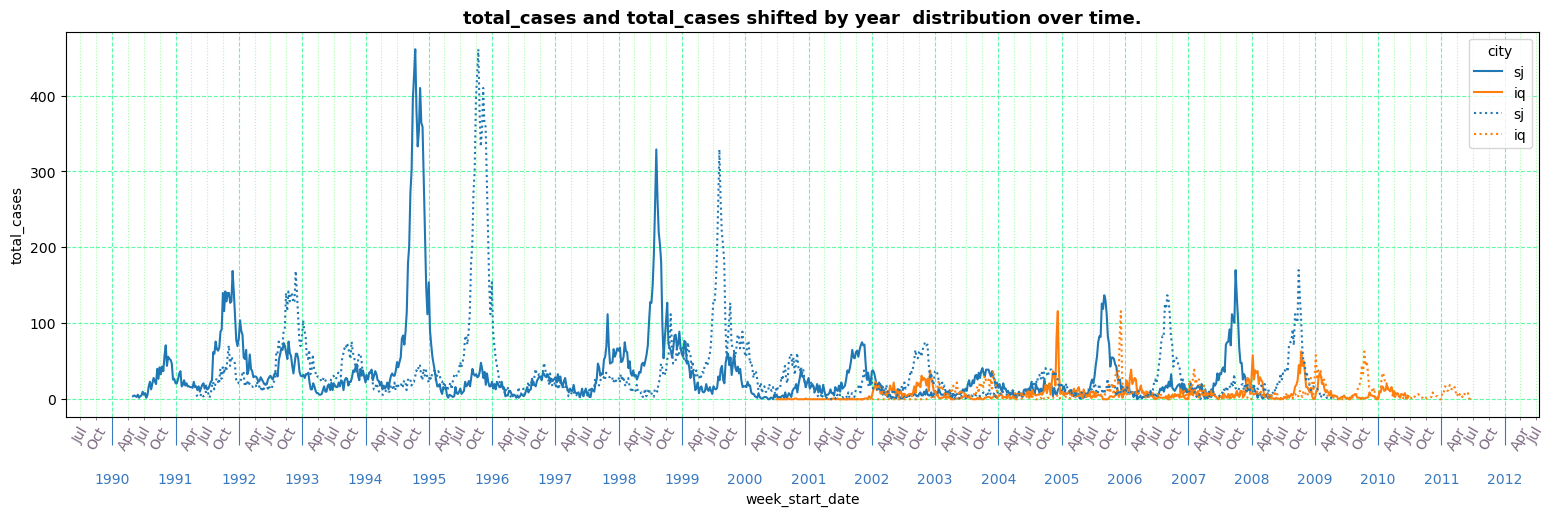

In [35]:
# Graph too saturated

# display_timeseries(data=df_train_raw[["city", "week_start_date"]].assign(total_cases=df_labels_raw[TARGET]),
#                    x="week_start_date",
#                    y=TARGET,
#                    hue="city",
#                    shift=52,
#                    title_prefix=f"{TARGET} and {TARGET} shifted by year")

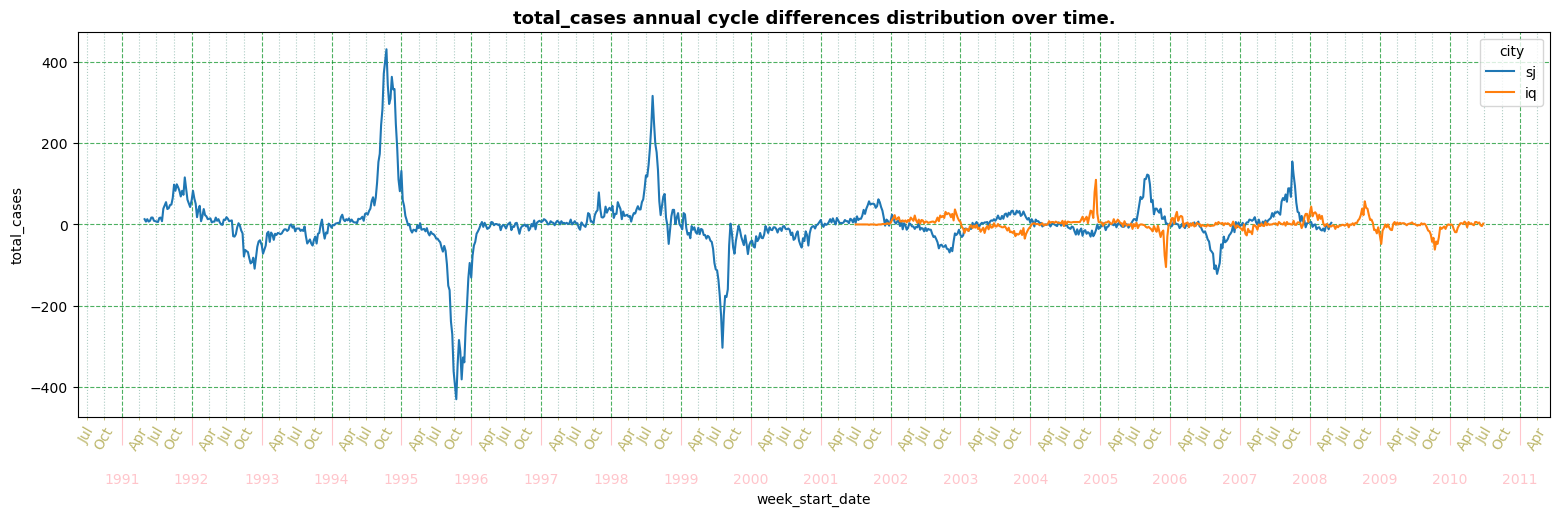

In [64]:
# a better way to display annual differences
display_timeseries(data=df_train_raw[["city", "week_start_date"]].assign(total_cases=df_labels_raw.groupby(by="city")[TARGET].diff(52)),
                   x="week_start_date",
                   y=TARGET,
                   hue="city",
                   title_prefix=f"{TARGET} annual cycle differences")

**Conclusion** There some annual patterns in San Juan (approx 2 yeare out of 20) and relatively more in Iquitos (approx 4 years out of 9):
- near zero values indicate annual patter streaks
- spikes indicate differences (most likely outbreak years):
    - San Juan has more outbreak patterns
- Tree models may handle such an interrupted seasonality better
    - with adittional feature engineering:
      - seasonal cyclical sin/cos features (weekly on annual basis)
      - weekly autocorrelation (must) or annual shift features (indicate time momentum for tree model)
      - Optional: annual diff feature for outbreak signals per city
      - # TODO (do a graph on annual rolling mean and then decide on feature relevance) Optional: rolling stats (mean, std?) to normalize outbreaks per city
-  RNNs (eg LSTM) will struggle with outbreak spikes as works best with smooth seasonal patterns:
    - still may benefit from  cyclical sin/cos features  

## TODO
- annual rolling average graph